In [3]:
pip install pandas-market-calendars

  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2023.3
    Uninstalling tzdata-2023.3:
      Successfully uninstalled tzdata-2023.3
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.0
    Uninstalling toolz-0.12.0:
      Successfully uninstalled toolz-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import pandas_market_calendars as mcal

# 1. Reload Data as UTC (The "Safe" Zone)
# We assume the file is the raw Binance one (which is UTC)
df = pd.read_csv("BTC_5min_Jan2023_Present.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df.index = df.index.tz_localize('UTC') # Explicitly tell Pandas this is UTC

# 2. Get NYSE Schedule in UTC
# We do NOT convert to Eastern here. We keep it UTC to match the dataframe.
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=df.index.min(), end_date=df.index.max())
open_minutes_utc = mcal.date_range(schedule, frequency='1T')

# 3. Apply Labels (Using UTC Matching)
# This will not error because UTC has no ambiguous DST hours.
df['State'] = 'Off-Hours'

# Check if the market is open (compare UTC to UTC)
is_market_open = df.index.floor('1T').isin(open_minutes_utc)
df.loc[is_market_open, 'State'] = 'ETF_Open'

# 4. NOW Convert to Eastern for the "Weekend" Check
# We need Eastern time to know when it's Saturday/Sunday
# (Converting just the index doesn't trigger the floor error)
df.index = df.index.tz_convert('US/Eastern')

# Apply Weekend Label (Overwriting Off-Hours, but respecting ETF_Open)
# Logic: If it's Sat/Sun AND the market wasn't open (which it shouldn't be anyway)
is_weekend = df.index.dayofweek >= 5
df.loc[is_weekend, 'State'] = 'Weekend'

# 5. Sanity Check
print("Success! Labels applied without DST crash.")
print("Check: Christmas 2024 (Wed):", df.loc['2024-12-25'].State.value_counts()) 
# Should contain only 'Off-Hours' (because it's a holiday, so not ETF_Open)

print("Check: Typical Friday vs Saturday:")
print(df.loc['2024-01-12 15:55':'2024-01-12 16:05'].State) 
# Should switch from ETF_Open to Off-Hours at 16:00

Success! Labels applied without DST crash.
Check: Christmas 2024 (Wed): State
Off-Hours    288
Name: count, dtype: int64
Check: Typical Friday vs Saturday:
datetime
2024-01-12 15:55:00-05:00     ETF_Open
2024-01-12 16:00:00-05:00     ETF_Open
2024-01-12 16:05:00-05:00    Off-Hours
Name: State, dtype: object


/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/4012250614.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  open_minutes_utc = mcal.date_range(schedule, frequency='1T')
/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/4012250614.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  is_market_open = df.index.floor('1T').isin(open_minutes_utc)


In [15]:
df_main = df.copy()

/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/1358144434.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Group'] = np.where(df.index < '2024-01-11', 'Pre-ETF (2023)', 'Post-ETF (2024-25)')


<Figure size 1000x500 with 0 Axes>

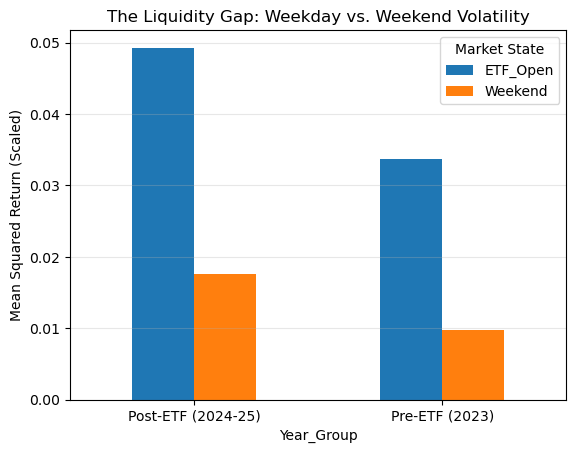

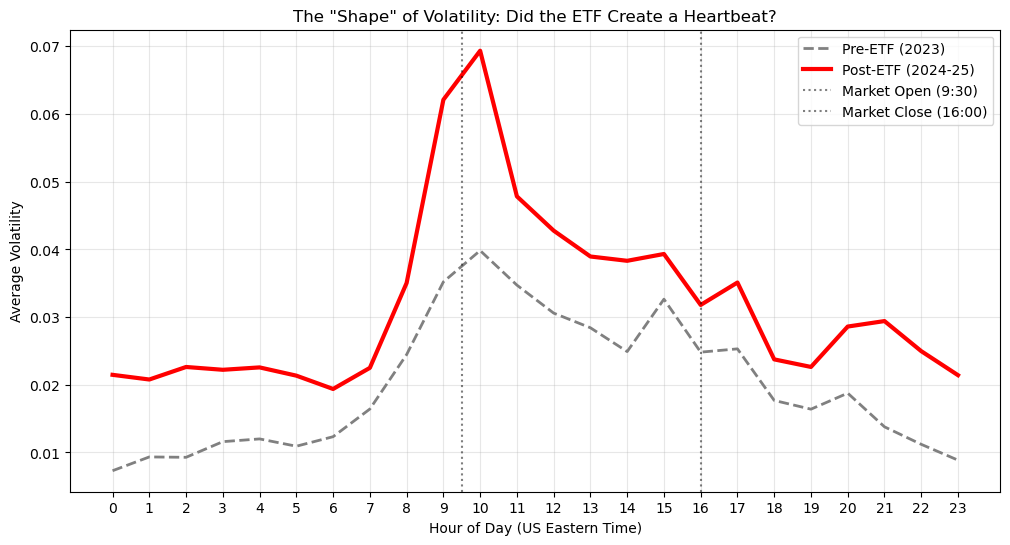

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Calculate Instantaneous Volatility ---
# We use Squared Returns as the proxy for Variance (Standard in microstructure)
df['Return'] = df['Close'].pct_change()
df['Realized_Vol'] = df['Return'] ** 2 

# Remove the very first row (NaN)
df = df.dropna()

# Create Pre/Post Label
df['Year_Group'] = np.where(df.index < '2024-01-11', 'Pre-ETF (2023)', 'Post-ETF (2024-25)')

# --- VISUALIZATION 1: The "Gap Width" (Bar Chart) ---
# We group by Year and State (Weekend vs ETF_Open)
# We multiply by 10,000 to make the numbers readable (Basis Points)
gap_data = df.groupby(['Year_Group', 'State'])['Realized_Vol'].mean().unstack()
gap_data = gap_data[['ETF_Open', 'Weekend']] # Select only the two states we care about

plt.figure(figsize=(10, 5))
# Plot
(gap_data * 10000).plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('The Liquidity Gap: Weekday vs. Weekend Volatility')
plt.ylabel('Mean Squared Return (Scaled)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Market State')
plt.show()


# --- VISUALIZATION 2: The "Shape" (Intraday Profile) ---
# We want to see the "Heartbeat" of the market Hour-by-Hour (US Eastern Time)

# Filter for Weekdays Only (since we want to see the ETF Open/Close effect)
weekdays_only = df[df.index.dayofweek < 5].copy()

# Extract the Hour of the day (0 to 23)
weekdays_only['Hour'] = weekdays_only.index.hour

# Calculate average volatility per hour, split by Year
hourly_profile = weekdays_only.groupby(['Hour', 'Year_Group'])['Realized_Vol'].mean().unstack()

plt.figure(figsize=(12, 6))
# Plot Pre-ETF Line
plt.plot(hourly_profile.index, hourly_profile['Pre-ETF (2023)'] * 10000, 
         label='Pre-ETF (2023)', color='gray', linestyle='--', linewidth=2)

# Plot Post-ETF Line
plt.plot(hourly_profile.index, hourly_profile['Post-ETF (2024-25)'] * 10000, 
         label='Post-ETF (2024-25)', color='red', linewidth=3)

# Add markers for ETF Open/Close
plt.axvline(x=9.5, color='black', linestyle=':', alpha=0.5, label='Market Open (9:30)')
plt.axvline(x=16, color='black', linestyle=':', alpha=0.5, label='Market Close (16:00)')

plt.title('The "Shape" of Volatility: Did the ETF Create a Heartbeat?')
plt.xlabel('Hour of Day (US Eastern Time)')
plt.ylabel('Average Volatility')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
import statsmodels.formula.api as smf

# --- STEP 1: PREPARE THE DATA FOR REGRESSION ---
# We work on a copy to be safe
reg_df = df.copy()

# 1. Scale the Volatility
# Squared returns are tiny (e.g., 0.000005). We multiply by 1,000,000 (1e6) 
# so the regression coefficients are readable numbers like "5.2" instead of "0.0000052"
reg_df['Scaled_Vol'] = reg_df['Realized_Vol'] * 1_000_000

# 2. Create Dummy Variables (0 or 1)
# Post_ETF: 1 if date is after Jan 11, 2024, else 0
reg_df['Dummy_Post'] = np.where(reg_df.index >= '2024-01-11', 1, 0)

# Weekend: 1 if State is 'Weekend', else 0
reg_df['Dummy_Weekend'] = np.where(reg_df['State'] == 'Weekend', 1, 0)

# 3. Create the Interaction Term (The "PhD Variable")
# This captures the specific effect of "Being on a Weekend AND in the Post-ETF era"
reg_df['Interaction'] = reg_df['Dummy_Post'] * reg_df['Dummy_Weekend']

# 4. Create the "Martingale" Control (Lagged Volatility)
# We shift volatility by 1 row (previous 5 minutes) to control for momentum
reg_df['Lagged_Vol'] = reg_df['Scaled_Vol'].shift(1)

# Drop NaN created by the shift
reg_df = reg_df.dropna()

# --- STEP 2: RUN THE REGRESSIONS ---

# MODEL 1: The Basic DiD
# Equation: Vol = Intercept + Post + Weekend + (Post * Weekend)
print("----------------------------------------------------------------")
print("MODEL 1: Basic Difference-in-Differences")
print("Hypothesis: The Interaction term should be significant.")
print("----------------------------------------------------------------")
model1 = smf.ols("Scaled_Vol ~ Dummy_Post + Dummy_Weekend + Interaction", data=reg_df).fit()
print(model1.summary())

print("\n\n")

# MODEL 2: The Robust "Martingale" Control
# Equation: Vol = ... + Previous_Vol
# This proves the effect isn't just because 'volatility clusters' together.
print("----------------------------------------------------------------")
print("MODEL 2: DiD with Autocorrelation Control (Lagged Vol)")
print("Hypothesis: Interaction should REMAIN significant even after controlling for Lag.")
print("----------------------------------------------------------------")
model2 = smf.ols("Scaled_Vol ~ Dummy_Post + Dummy_Weekend + Interaction + Lagged_Vol", data=reg_df).fit()
print(model2.summary())

----------------------------------------------------------------
MODEL 1: Basic Difference-in-Differences
Hypothesis: The Interaction term should be significant.
----------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:             Scaled_Vol   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     531.6
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:50:45   Log-Likelihood:            -1.1596e+06
No. Observations:              305449   AIC:                         2.319e+06
Df Residuals:                  305445   BIC:                         2.319e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                         

In [18]:
# --- DEBUG & MODEL 2 BLOCK ---
# 1. Check if the data exists and is clean
print("Checking regression data...")
# If reg_df doesn't exist, we recreate it quickly
if 'reg_df' not in locals():
    reg_df = df.copy()
    reg_df['Scaled_Vol'] = reg_df['Realized_Vol'] * 1_000_000
    reg_df['Dummy_Post'] = np.where(reg_df.index >= '2024-01-11', 1, 0)
    reg_df['Dummy_Weekend'] = np.where(reg_df['State'] == 'Weekend', 1, 0)
    reg_df['Interaction'] = reg_df['Dummy_Post'] * reg_df['Dummy_Weekend']
    reg_df['Lagged_Vol'] = reg_df['Scaled_Vol'].shift(1)
    reg_df = reg_df.dropna()

print(f"Data Rows: {len(reg_df)}")
print(f"NaN Values: {reg_df.isnull().sum().sum()}")

# 2. Run Model 2 Only
print("\nRunning Model 2 (Martingale Control)...")
model2 = smf.ols("Scaled_Vol ~ Dummy_Post + Dummy_Weekend + Interaction + Lagged_Vol", data=reg_df).fit()

# 3. Print Summary
print(model2.summary())

Checking regression data...
Data Rows: 305449
NaN Values: 0

Running Model 2 (Martingale Control)...
                            OLS Regression Results                            
Dep. Variable:             Scaled_Vol   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     3831.
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:53:34   Log-Likelihood:            -1.1530e+06
No. Observations:              305449   AIC:                         2.306e+06
Df Residuals:                  305444   BIC:                         2.306e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

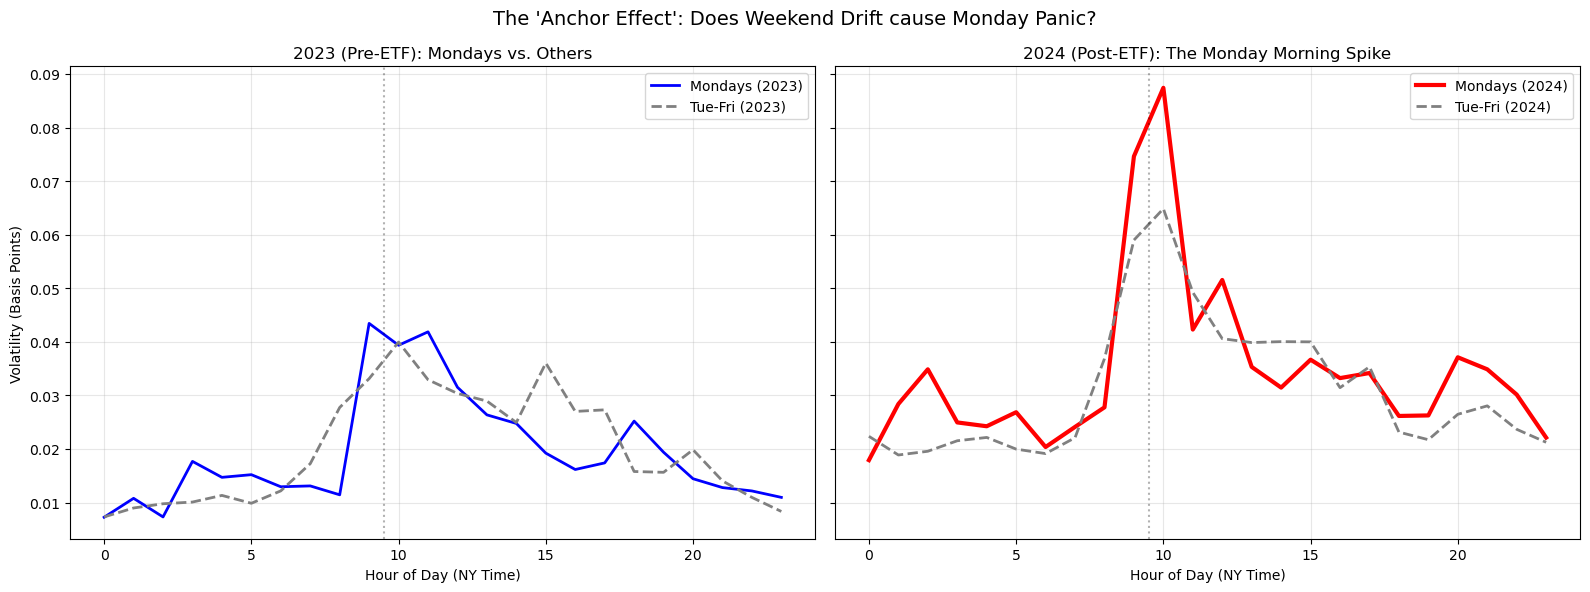

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- DATA PREP (Assuming df is already loaded/labeled from previous steps) ---
# We work on a copy
plot_df = df.copy()

# Ensure we have the calculated Volatility
plot_df['Return'] = plot_df['Close'].pct_change()
plot_df['Realized_Vol'] = plot_df['Return'] ** 2 
plot_df = plot_df.dropna()

# Create Filters
is_monday = plot_df.index.dayofweek == 0
is_tue_fri = (plot_df.index.dayofweek >= 1) & (plot_df.index.dayofweek <= 4)

# Create Year Groups
plot_df['Year_Group'] = np.where(plot_df.index < '2024-01-11', 'Pre-ETF (2023)', 'Post-ETF (2024-25)')

# --- CALCULATE INTRADAY PROFILES ---
# We aggregate by Hour to see the shape
# 1. Mondays Only
monday_profile = plot_df[is_monday].groupby(['Year_Group', plot_df[is_monday].index.hour])['Realized_Vol'].mean().unstack(level=0)

# 2. Other Weekdays (Tue-Fri)
other_profile = plot_df[is_tue_fri].groupby(['Year_Group', plot_df[is_tue_fri].index.hour])['Realized_Vol'].mean().unstack(level=0)

# --- THE PLOT ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# CHART 1: PRE-ETF (2023)
# We compare Mon vs Others in the OLD era
axes[0].plot(monday_profile.index, monday_profile['Pre-ETF (2023)'] * 10000, 
             color='blue', linestyle='-', linewidth=2, label='Mondays (2023)')
axes[0].plot(other_profile.index, other_profile['Pre-ETF (2023)'] * 10000, 
             color='gray', linestyle='--', linewidth=2, label='Tue-Fri (2023)')
axes[0].set_title("2023 (Pre-ETF): Mondays vs. Others")
axes[0].set_xlabel("Hour of Day (NY Time)")
axes[0].set_ylabel("Volatility (Basis Points)")
axes[0].axvline(9.5, color='k', linestyle=':', alpha=0.3)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CHART 2: POST-ETF (2024) - THIS IS THE MONEY PLOT
# We compare Mon vs Others in the NEW era
axes[1].plot(monday_profile.index, monday_profile['Post-ETF (2024-25)'] * 10000, 
             color='red', linestyle='-', linewidth=3, label='Mondays (2024)')
axes[1].plot(other_profile.index, other_profile['Post-ETF (2024-25)'] * 10000, 
             color='gray', linestyle='--', linewidth=2, label='Tue-Fri (2024)')
axes[1].set_title("2024 (Post-ETF): The Monday Morning Spike")
axes[1].set_xlabel("Hour of Day (NY Time)")
axes[1].axvline(9.5, color='k', linestyle=':', alpha=0.3)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("The 'Anchor Effect': Does Weekend Drift cause Monday Panic?", fontsize=14)
plt.tight_layout()
plt.show()

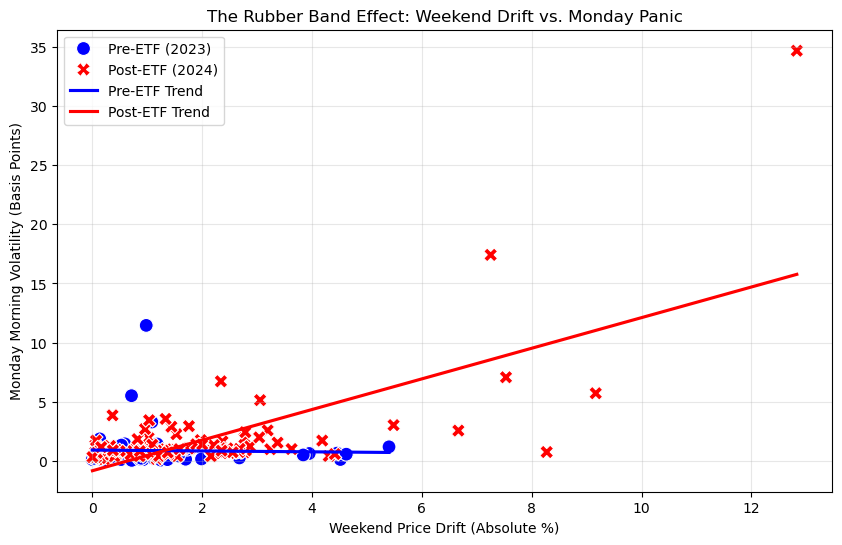

Correlation (Drift -> Panic) Pre-ETF: -0.03
Correlation (Drift -> Panic) Post-ETF: 0.68


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: PREPARE DATA ---
work_df = df.copy() # Use your main dataframe
work_df['Day'] = work_df.index.day_name()

# 1. Get Friday Closes
# Resample to Weekly-Friday and take the last price
fridays = work_df[work_df['Day'] == 'Friday']['Close'].resample('W-FRI').last()

# 2. Get Monday Opens
# Resample to Weekly-Monday and take the first price
mondays = work_df[work_df['Day'] == 'Monday']['Open'].resample('W-MON').first()

# 3. Get Monday Morning Volatility (Panic)
# Filter for 9:30-10:30 AM on Mondays
monday_morning_mask = (work_df['Day'] == 'Monday') & (work_df.index.hour.isin([9, 10]))
monday_vol = work_df[monday_morning_mask]['Realized_Vol'].resample('W-MON').sum()

# --- STEP 2: ALIGNMENT (The Fix) ---
# We shift the Friday index forward by 3 days so it "pretends" to be the following Monday.
# This allows us to join them perfectly on the "Monday" date.
fridays_shifted = fridays.copy()
fridays_shifted.index = fridays.index + pd.Timedelta(days=3)

# Rename Series for clarity before merging
fridays_shifted.name = 'Friday_Close'
mondays.name = 'Monday_Open'
monday_vol.name = 'Monday_Vol'

# Merge them all into one DataFrame based on the Index (Date)
stats_df = pd.concat([fridays_shifted, mondays, monday_vol], axis=1)

# Drop any rows where we don't have BOTH a Friday and a Monday (e.g. holidays or start/end of data)
stats_df = stats_df.dropna()

# --- STEP 3: CALCULATE VARIABLES ---
# Drift = (Monday Open - Friday Close) / Friday Close
stats_df['Weekend_Return'] = (stats_df['Monday_Open'] - stats_df['Friday_Close']) / stats_df['Friday_Close']
stats_df['Abs_Drift'] = stats_df['Weekend_Return'].abs() * 100 # Percentage
stats_df['Monday_Vol_Scaled'] = stats_df['Monday_Vol'] * 10000

# Create Period Labels
stats_df['Period'] = np.where(stats_df.index < '2024-01-11', 'Pre-ETF (2023)', 'Post-ETF (2024)')

# --- STEP 4: PLOT ---
plt.figure(figsize=(10, 6))

# Scatter Plot with different colors for Pre/Post ETF
sns.scatterplot(
    data=stats_df, 
    x='Abs_Drift', 
    y='Monday_Vol_Scaled', 
    hue='Period', 
    style='Period', 
    s=100,
    palette={'Pre-ETF (2023)': 'blue', 'Post-ETF (2024)': 'red'}
)

# Add Trendlines (Regression Lines)
sns.regplot(data=stats_df[stats_df['Period']=='Pre-ETF (2023)'], x='Abs_Drift', y='Monday_Vol_Scaled', 
            scatter=False, color='blue', label='Pre-ETF Trend', ci=None)
sns.regplot(data=stats_df[stats_df['Period']=='Post-ETF (2024)'], x='Abs_Drift', y='Monday_Vol_Scaled', 
            scatter=False, color='red', label='Post-ETF Trend', ci=None)

plt.title('The Rubber Band Effect: Weekend Drift vs. Monday Panic')
plt.xlabel('Weekend Price Drift (Absolute %)')
plt.ylabel('Monday Morning Volatility (Basis Points)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- STEP 5: CORRELATION STATS ---
corr_pre = stats_df[stats_df['Period']=='Pre-ETF (2023)']['Abs_Drift'].corr(stats_df[stats_df['Period']=='Pre-ETF (2023)']['Monday_Vol_Scaled'])
corr_post = stats_df[stats_df['Period']=='Post-ETF (2024)']['Abs_Drift'].corr(stats_df[stats_df['Period']=='Post-ETF (2024)']['Monday_Vol_Scaled'])

print(f"Correlation (Drift -> Panic) Pre-ETF: {corr_pre:.2f}")
print(f"Correlation (Drift -> Panic) Post-ETF: {corr_post:.2f}")

/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/1237451786.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = df['Close'].pct_change()
/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/1237451786.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dollar_Volume'] = df['Volume'] * df['Close']
/var/folders/9h/0y5x8lz50_91q3vx4bly1x_40000gn/T/ipykernel_53353/1237451786.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

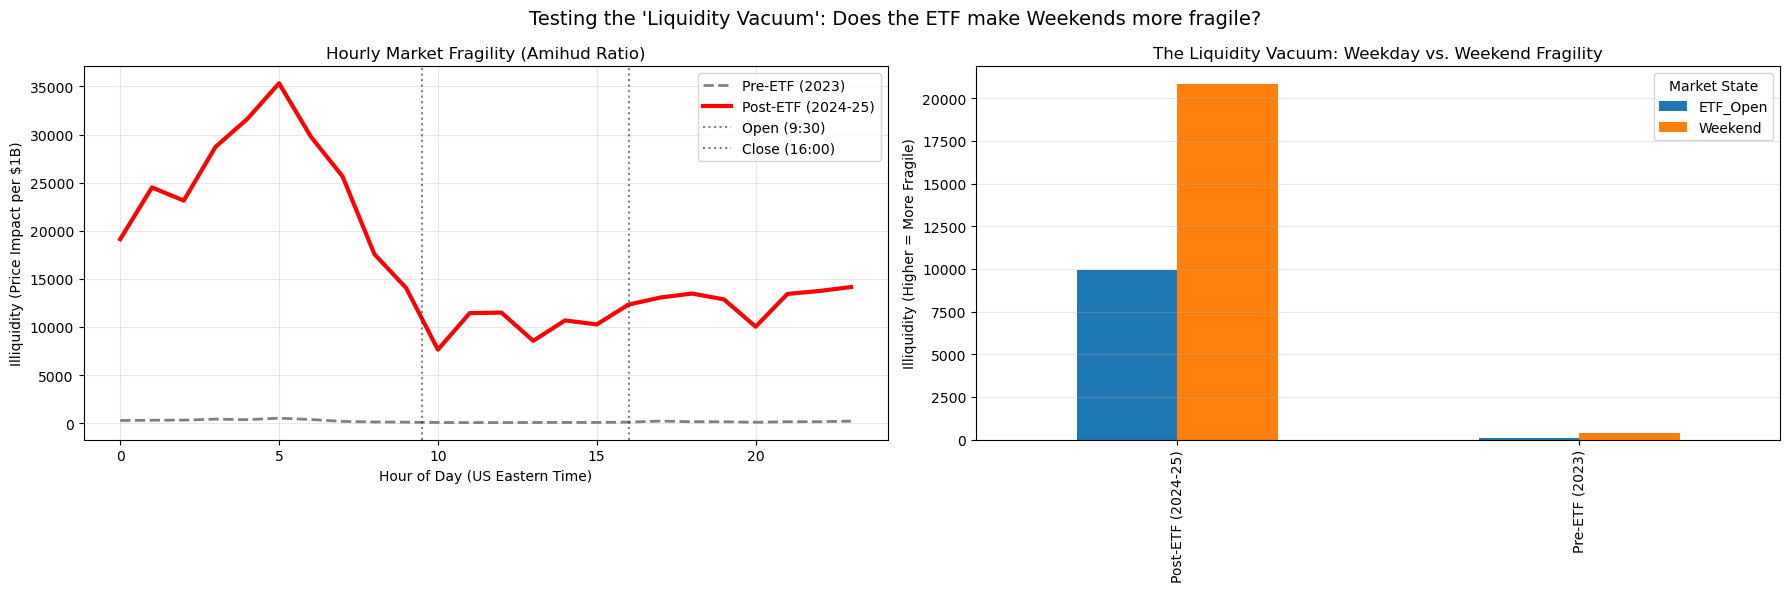


--- Mean Amihud Illiquidity (Lower is Better) ---
State                  ETF_Open       Weekend
Year_Group                                   
Post-ETF (2024-25)  9937.404878  20832.646678
Pre-ETF (2023)        63.450974    406.630175


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: CALCULATE AMIHUD RATIO ---
# Formula: |Return| / (Price * Volume)
# This tells us: "How much price impact per $1 traded?"

# We assume 'df' is your main dataframe from previous steps
# If starting fresh, uncomment these lines:
# df = pd.read_csv("BTC_5min_MASTER_2023_2025.csv")
# df['datetime'] = pd.to_datetime(df['datetime'])
# df = df.set_index('datetime')
# df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')

# Ensure Returns are calculated
df['Return'] = df['Close'].pct_change()

# Calculate Dollar Volume
df['Dollar_Volume'] = df['Volume'] * df['Close']

# Handle Zero Volume (avoid division by zero)
# We replace 0 volume with NaN or a tiny number to prevent infinity errors
df['Dollar_Volume'] = df['Dollar_Volume'].replace(0, np.nan)

# Calculate Raw Amihud Ratio
df['Amihud_Raw'] = df['Return'].abs() / df['Dollar_Volume']

# SCALE IT: The raw number is tiny (e.g., 1e-12).
# We multiply by 1 Billion (1e9) to get "Price Impact per Billion Dollars" (readable units)
df['Amihud_Scaled'] = df['Amihud_Raw'] * 1_000_000_000

# Re-Create Year Labels if missing
df['Year_Group'] = np.where(df.index < '2024-01-11', 'Pre-ETF (2023)', 'Post-ETF (2024-25)')

# --- VISUALIZATION 1: THE HOURLY "FRAGILITY" PROFILE ---
# We want to see if fragility drops when the ETF opens

# Filter for Weekdays Only (to see the ETF Open effect clearly)
weekdays_only = df[df.index.dayofweek < 5].copy()
weekdays_only['Hour'] = weekdays_only.index.hour

# Group by Hour and Year
hourly_fragility = weekdays_only.groupby(['Hour', 'Year_Group'])['Amihud_Scaled'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# CHART A: Hourly Fragility (Weekdays)
axes[0].plot(hourly_fragility.index, hourly_fragility['Pre-ETF (2023)'], 
             label='Pre-ETF (2023)', color='gray', linestyle='--', linewidth=2)
axes[0].plot(hourly_fragility.index, hourly_fragility['Post-ETF (2024-25)'], 
             label='Post-ETF (2024-25)', color='red', linewidth=3)

# Add Market Hours Markers
axes[0].axvline(x=9.5, color='black', linestyle=':', alpha=0.5, label='Open (9:30)')
axes[0].axvline(x=16, color='black', linestyle=':', alpha=0.5, label='Close (16:00)')

axes[0].set_title('Hourly Market Fragility (Amihud Ratio)')
axes[0].set_xlabel('Hour of Day (US Eastern Time)')
axes[0].set_ylabel('Illiquidity (Price Impact per $1B)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- VISUALIZATION 2: THE "VACUUM" (Bar Chart) ---
# Compare ETF_Open vs Weekend Fragility

# Ensure 'State' column exists (from previous labeling steps)
# If not, run the 'Labeling' script first!
if 'State' in df.columns:
    fragility_summary = df.groupby(['Year_Group', 'State'])['Amihud_Scaled'].mean().unstack()
    fragility_summary = fragility_summary[['ETF_Open', 'Weekend']] # Select columns

    # CHART B: Bar Comparison
    fragility_summary.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
    axes[1].set_title('The Liquidity Vacuum: Weekday vs. Weekend Fragility')
    axes[1].set_ylabel('Illiquidity (Higher = More Fragile)')
    axes[1].set_xlabel('')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].legend(title='Market State')

plt.suptitle("Testing the 'Liquidity Vacuum': Does the ETF make Weekends more fragile?", fontsize=14)
plt.tight_layout()
plt.show()

# --- PRINT STATS ---
print("\n--- Mean Amihud Illiquidity (Lower is Better) ---")
print(fragility_summary)

Found 94 valid weekends.
Plotting 9118 data points...


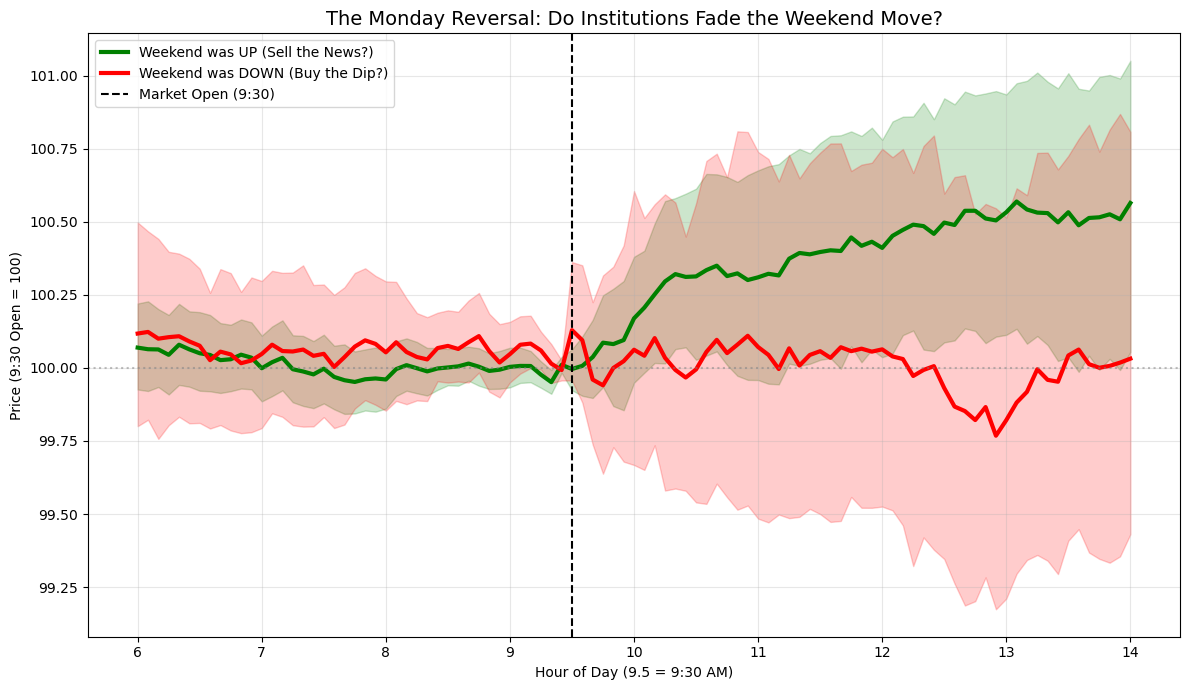

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: PREPARE DATA ---
# Ensure we are working with the correct timezone and year
# We assume 'df' is your main dataframe (already loaded and indexed)
work_df = df[df.index >= '2024-01-11'].copy() # Post-ETF only

# Safety Check: Ensure timezone is US/Eastern for 9:30 alignment
if str(work_df.index.tz) == 'UTC':
    work_df.index = work_df.index.tz_convert('US/Eastern')
elif str(work_df.index.tz) not in ['US/Eastern', 'America/New_York']:
    work_df.index = work_df.index.tz_localize('UTC').tz_convert('US/Eastern')

# --- STEP 2: CLASSIFY MONDAYS ---
# We need to know: Was the weekend UP or DOWN?

# Get Daily Open/Close to calculate weekend moves
# We use 'D' resampling which defaults to midnight
daily_close = work_df['Close'].resample('D').last()
daily_open = work_df['Open'].resample('D').first()

# Create a DataFrame of Mondays
mondays_list = daily_open[daily_open.index.dayofweek == 0].index
weekend_stats = pd.DataFrame(index=mondays_list)

# Find the previous Friday for each Monday
# We subtract 3 days from the Monday date to find the Friday date
weekend_stats['Friday_Date'] = weekend_stats.index - pd.Timedelta(days=3)

# Lookup prices (Using reindex to be safe)
# We map the dates to the price series
weekend_stats['Monday_Open'] = daily_open.reindex(weekend_stats.index)
weekend_stats['Friday_Close'] = daily_close.reindex(weekend_stats['Friday_Date']).values

# Calculate Drift
weekend_stats['Weekend_Ret'] = (weekend_stats['Monday_Open'] - weekend_stats['Friday_Close']) / weekend_stats['Friday_Close']
weekend_stats['Type'] = np.where(weekend_stats['Weekend_Ret'] > 0, 'Up Weekend', 'Down Weekend')

# Drop missing data (e.g. if a Friday is missing)
weekend_stats = weekend_stats.dropna()
print(f"Found {len(weekend_stats)} valid weekends.")

# --- STEP 3: PREPARE INTRADAY DATA ---
normalized_dfs = []

# Loop through each valid Monday
for date in weekend_stats.index:
    try:
        # Get data for this specific Monday (6 AM to 2 PM)
        # We filter the main dataframe for this specific date
        day_data = work_df[work_df.index.date == date.date()].copy()
        
        # Filter for time window
        day_data = day_data.between_time('06:00', '14:00')
        
        if day_data.empty:
            continue

        # FIND REFERENCE PRICE (The Fix)
        # Instead of strict indexing, find the first row after 9:30
        market_open_data = day_data.between_time('09:30', '10:00')
        
        if market_open_data.empty:
            # Fallback: Just take the closest time to 9:30 we have
            # If no data at 9:30, use the middle of the available data
            ref_price = day_data.iloc[len(day_data)//2]['Open'] 
        else:
            ref_price = market_open_data.iloc[0]['Open'] # First trade after 9:30

        # Normalize
        day_data['Normalized'] = (day_data['Close'] / ref_price) * 100
        
        # Add metadata
        day_data['Type'] = weekend_stats.loc[date, 'Type']
        day_data['Time'] = day_data.index.time
        
        normalized_dfs.append(day_data)
        
    except Exception as e:
        continue

if not normalized_dfs:
    print("ERROR: No data found for plotting. Check your dataframe index.")
else:
    plot_data = pd.concat(normalized_dfs)
    print(f"Plotting {len(plot_data)} data points...")

    # --- STEP 4: PLOT ---
    plt.figure(figsize=(12, 7))

    # We convert 'Time' to a numeric value (Hours) for smoother plotting if needed, 
    # but seaborn handles time objects well usually. 
    # To fix the "Invalid object type" error, we might need to convert time to string or float.
    # Let's convert to float hours for safety:
    plot_data['Hour_Float'] = plot_data.index.hour + plot_data.index.minute / 60

    # Plot Lines
    sns.lineplot(data=plot_data[plot_data['Type']=='Up Weekend'], x='Hour_Float', y='Normalized', 
                 color='green', label='Weekend was UP (Sell the News?)', linewidth=3)
    
    sns.lineplot(data=plot_data[plot_data['Type']=='Down Weekend'], x='Hour_Float', y='Normalized', 
                 color='red', label='Weekend was DOWN (Buy the Dip?)', linewidth=3)

    # Reference Line
    plt.axvline(x=9.5, color='black', linestyle='--', label='Market Open (9:30)')
    plt.axhline(y=100, color='gray', linestyle=':', alpha=0.5)

    plt.title('The Monday Reversal: Do Institutions Fade the Weekend Move?', fontsize=14)
    plt.ylabel('Price (9:30 Open = 100)')
    plt.xlabel('Hour of Day (9.5 = 9:30 AM)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

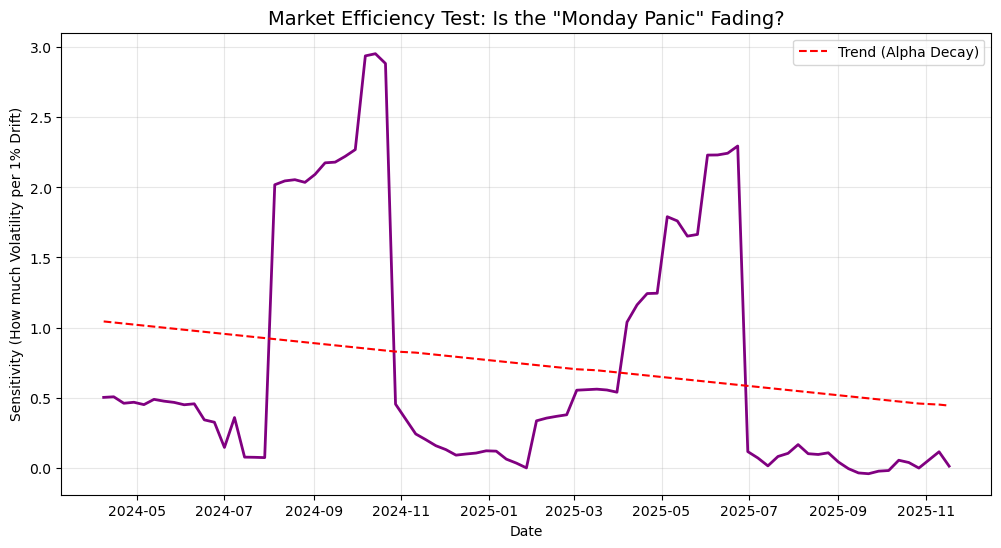

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# --- STEP 1: PREPARE WEEKLY DATA ---
# We reuse the logic from the Scatter Plot calculation
# Assuming 'work_df' is your main Post-ETF dataframe (Jan 2024 - Nov 2025)
work_df = df[df.index >= '2024-01-11'].copy()
work_df['Day'] = work_df.index.day_name()

# Get Friday Closes and Monday Opens
fridays = work_df[work_df['Day'] == 'Friday']['Close'].resample('W-FRI').last()
mondays = work_df[work_df['Day'] == 'Monday']['Open'].resample('W-MON').first()

# Get Monday Morning Volatility (9:30-10:30)
monday_morning_mask = (work_df['Day'] == 'Monday') & (work_df.index.hour.isin([9, 10]))
monday_vol = work_df[monday_morning_mask]['Realized_Vol'].resample('W-MON').sum()

# Align
fridays_shifted = fridays.copy()
fridays_shifted.index = fridays.index + pd.Timedelta(days=3)
stats_df = pd.concat([fridays_shifted, mondays, monday_vol], axis=1).dropna()
stats_df.columns = ['Friday_Close', 'Monday_Open', 'Monday_Vol']

# Calculate Variables
stats_df['Abs_Drift'] = ((stats_df['Monday_Open'] - stats_df['Friday_Close']) / stats_df['Friday_Close']).abs() * 100
stats_df['Monday_Vol_Scaled'] = stats_df['Monday_Vol'] * 10000

# --- STEP 2: ROLLING REGRESSION ---
# We want to see how the "Slope" (Beta) changes over time
# We use a rolling window of 12 weeks (approx 1 quarter)

window_size = 12
betas = []
dates = []

for i in range(window_size, len(stats_df)):
    window_data = stats_df.iloc[i-window_size:i]
    
    # Run simple regression: Vol = alpha + beta * Drift
    X = window_data[['Abs_Drift']]
    y = window_data['Monday_Vol_Scaled']
    
    model = LinearRegression().fit(X, y)
    betas.append(model.coef_[0])
    dates.append(window_data.index[-1])

# Create Result DataFrame
decay_df = pd.DataFrame({'Date': dates, 'Sensitivity_Beta': betas}).set_index('Date')

# --- STEP 3: PLOT THE DECAY ---
plt.figure(figsize=(12, 6))
plt.plot(decay_df.index, decay_df['Sensitivity_Beta'], color='purple', linewidth=2)

# Add Trendline to the Decay
z = np.polyfit(range(len(decay_df)), decay_df['Sensitivity_Beta'], 1)
p = np.poly1d(z)
plt.plot(decay_df.index, p(range(len(decay_df))), "r--", label='Trend (Alpha Decay)')

plt.title('Market Efficiency Test: Is the "Monday Panic" Fading?', fontsize=14)
plt.ylabel('Sensitivity (How much Volatility per 1% Drift)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()